In [1]:


import tensorflow as tf
import nibabel as nib
import numpy as np
import os
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from scipy.ndimage import zoom, rotate, shift
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# In[2]:


import nibabel as nib
import numpy as np
from skimage.transform import resize
import os

# Directories
healthy_directory = "nd/healthy/"
schiz_directory = "nd/schizophrenia/"
he_directory = "resized/healthy/"
sz_directory = "resized/schizophrenia/"

def resize_data(data, new_shape):
    # Resize each slice independently
    resized_slices = np.zeros((data.shape[0], new_shape[0], new_shape[1]))
    for i in range(data.shape[0]):
        resized_slices[i, :, :] = resize(data[i, :, :], new_shape, mode='reflect', anti_aliasing=True)
    return resized_slices

def process_and_resize_directory(input_directory, output_directory, slice_start, slice_end, new_shape):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    print(f"Listing files in directory: {input_directory}")
    files = os.listdir(input_directory)
    print(f"Files found: {files}")

    files_processed = False  # Flag to check if any file was processed

    for filename in files:
        if filename.endswith('.nii'):
            file_path = os.path.join(input_directory, filename)
            try:
                print(f"Processing file: {file_path}")

                # Load the NIfTI file
                img = nib.load(file_path)
                data = img.get_fdata()  # Get the image data as a NumPy array

                print(f"Original data shape: {data.shape}")

                # Extract middle slices
                middle_slices = data[slice_start:slice_end, :, :]

                # Resize each slice
                resized_slices = resize_data(middle_slices, new_shape)

                # Save the resized data
                new_file_path = os.path.join(output_directory, f"resized_{filename}")
                new_img = nib.Nifti1Image(resized_slices, img.affine)
                nib.save(new_img, new_file_path)
                print(f"Resized and saved {filename} to {new_file_path}")

                files_processed = True
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    if not files_processed:
        print(f"No files processed in directory: {input_directory}")

# Define the range of slices you want to extract
slice_start = 86
slice_end = 106  # Note that end is exclusive

# Define the new shape
new_shape = (128, 128)

# Process and resize both directories
process_and_resize_directory(healthy_directory, he_directory, slice_start, slice_end, new_shape)
process_and_resize_directory(schiz_directory, sz_directory, slice_start, slice_end, new_shape)


# In[3]:


import albumentations as A
import nibabel as nib
import numpy as np
import os
from sklearn.utils import shuffle
from albumentations.pytorch import ToTensorV2

# Directories
he_directory = "resized/healthy/"
sz_directory = "resized/schizophrenia/"

# Augmentation pipeline
def get_augmentation_pipeline():
    return A.Compose([
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
        A.Resize(height=128, width=128),  # Resize to a common shape if needed
        ToTensorV2()  # Convert to PyTorch tensors if using PyTorch
    ])

def load_images_and_labels(directory, label, augmentation=None):
    files = [f for f in os.listdir(directory) if f.endswith('.nii')]
    images = []
    for file in files:
        file_path = os.path.join(directory, file)
        img = nib.load(file_path)
        data = img.get_fdata()

        # Apply augmentation if provided
        if augmentation:
            for i in range(data.shape[0]):  # Apply augmentation to each slice
                augmented = augmentation(image=data[i])
                images.append(augmented['image'])
        else:
            images.extend(data)

    return np.array(images), np.full(len(images), label)

# Define augmentation pipeline
augmentation_pipeline = get_augmentation_pipeline()

# Load and augment data
S_healthy_images, healthy_labels = load_images_and_labels(he_directory, 0, augmentation=augmentation_pipeline)
S_schiz_images, schiz_labels = load_images_and_labels(sz_directory, 1, augmentation=augmentation_pipeline)

# Concatenate the healthy and diseased data into a single array
S_data = np.concatenate((S_healthy_images, S_schiz_images), axis=0)
S_labels = np.concatenate((healthy_labels, schiz_labels), axis=0)

# Shuffle the data and labels together
S_data, S_labels = shuffle(S_data, S_labels, random_state=42)

# Split the data and labels into training and testing sets
split_index = int(len(S_data) * 0.8)  # 80% for training

S_train_data = S_data[:split_index]
S_test_data = S_data[split_index:]
S_train_labels = S_labels[:split_index]
S_test_labels = S_labels[split_index:]

print(f"Training data shape: {S_train_data.shape}")
print(f"Testing data shape: {S_test_data.shape}")
print(f"Training labels shape: {S_train_labels.shape}")
print(f"Testing labels shape: {S_test_labels.shape}")

Listing files in directory: nd/healthy/
Files found: ['sub-101_T1w.nii', 'sub-102_T1w.nii', 'sub-10_T1w.nii', 'sub-11_T1w.nii', 'sub-12_T1w.nii', 'sub-13_T1w.nii', 'sub-14_T1w.nii', 'sub-15_T1w.nii', 'sub-16_T1w.nii', 'sub-20_T1w.nii', 'sub-35_T1w.nii', 'sub-36_T1w.nii', 'sub-37_T1w.nii', 'sub-38_T1w.nii', 'sub-43_T1w.nii', 'sub-46_T1w.nii', 'sub-47_T1w.nii', 'sub-49_T1w.nii', 'sub-50_T1w.nii', 'sub-51_T1w.nii', 'sub-53_T1w.nii', 'sub-54_T1w.nii', 'sub-55_T1w.nii', 'sub-56_T1w.nii', 'sub-57_T1w.nii', 'sub-58_T1w.nii', 'sub-59_T1w.nii', 'sub-64_T1w.nii', 'sub-65_T1w.nii', 'sub-69_T1w.nii', 'sub-72_T1w.nii', 'sub-73_T1w.nii', 'sub-81_T1w.nii', 'sub-87_T1w.nii', 'sub-88_T1w.nii', 'sub-89_T1w.nii', 'sub-90_T1w.nii', 'sub-97_T1w.nii', 'sub-98_T1w.nii', 'sub-A00000300_ses-20110101_acq-mprage_run-01_T1w.nii', 'sub-A00002198_ses-20110101_acq-mprage_run-01_T1w.nii', 'sub-A00003150_ses-20110101_acq-mprage_run-01_T1w.nii', 'sub-A00004087_ses-20100101_acq-mprage_run-04_T1w.nii', 'sub-A00007409_ses

Resized and saved sub-47_T1w.nii to resized/healthy/resized_sub-47_T1w.nii
Processing file: nd/healthy/sub-49_T1w.nii
Original data shape: (176, 256, 256)
Resized and saved sub-49_T1w.nii to resized/healthy/resized_sub-49_T1w.nii
Processing file: nd/healthy/sub-50_T1w.nii
Original data shape: (176, 256, 256)
Resized and saved sub-50_T1w.nii to resized/healthy/resized_sub-50_T1w.nii
Processing file: nd/healthy/sub-51_T1w.nii
Original data shape: (176, 256, 256)
Resized and saved sub-51_T1w.nii to resized/healthy/resized_sub-51_T1w.nii
Processing file: nd/healthy/sub-53_T1w.nii
Original data shape: (176, 256, 256)
Resized and saved sub-53_T1w.nii to resized/healthy/resized_sub-53_T1w.nii
Processing file: nd/healthy/sub-54_T1w.nii
Original data shape: (176, 256, 256)
Resized and saved sub-54_T1w.nii to resized/healthy/resized_sub-54_T1w.nii
Processing file: nd/healthy/sub-55_T1w.nii
Original data shape: (176, 256, 256)
Resized and saved sub-55_T1w.nii to resized/healthy/resized_sub-55_T1w

Original data shape: (192, 256, 256)
Resized and saved sub-A00015759_ses-20120101_acq-mprage_run-02_T1w.nii to resized/healthy/resized_sub-A00015759_ses-20120101_acq-mprage_run-02_T1w.nii
Processing file: nd/healthy/sub-A00015826_ses-20110101_acq-mprage_run-01_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00015826_ses-20110101_acq-mprage_run-01_T1w.nii to resized/healthy/resized_sub-A00015826_ses-20110101_acq-mprage_run-01_T1w.nii
Processing file: nd/healthy/sub-A00017294_ses-20110101_acq-mprage_run-02_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00017294_ses-20110101_acq-mprage_run-02_T1w.nii to resized/healthy/resized_sub-A00017294_ses-20110101_acq-mprage_run-02_T1w.nii
Processing file: nd/healthy/sub-A00018335_ses-20090101_acq-mprage_run-01_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00018335_ses-20090101_acq-mprage_run-01_T1w.nii to resized/healthy/resized_sub-A00018335_ses-20090101_acq-mprage_run-01_T1w.nii
Proce

Resized and saved sub-A00023143_ses-20090101_acq-mprage_run-01_T1w.nii to resized/healthy/resized_sub-A00023143_ses-20090101_acq-mprage_run-01_T1w.nii
Processing file: nd/healthy/sub-A00023330_ses-20090101_acq-mprage_run-01_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00023330_ses-20090101_acq-mprage_run-01_T1w.nii to resized/healthy/resized_sub-A00023330_ses-20090101_acq-mprage_run-01_T1w.nii
Processing file: nd/healthy/sub-A00023337_ses-20100101_acq-mprage_run-01_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00023337_ses-20100101_acq-mprage_run-01_T1w.nii to resized/healthy/resized_sub-A00023337_ses-20100101_acq-mprage_run-01_T1w.nii
Processing file: nd/healthy/sub-A00023730_ses-20120101_acq-mprage_run-01_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00023730_ses-20120101_acq-mprage_run-01_T1w.nii to resized/healthy/resized_sub-A00023730_ses-20120101_acq-mprage_run-01_T1w.nii
Processing file: nd/healthy/sub-A00023800_

Original data shape: (192, 256, 256)
Resized and saved sub-A00036897_ses-20130101_acq-mprage_run-02_T1w.nii to resized/healthy/resized_sub-A00036897_ses-20130101_acq-mprage_run-02_T1w.nii
Processing file: nd/healthy/sub-A00036916_ses-20130101_acq-mprage_run-01_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00036916_ses-20130101_acq-mprage_run-01_T1w.nii to resized/healthy/resized_sub-A00036916_ses-20130101_acq-mprage_run-01_T1w.nii
Processing file: nd/healthy/sub-A00037007_ses-20130101_acq-mprage_run-02_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00037007_ses-20130101_acq-mprage_run-02_T1w.nii to resized/healthy/resized_sub-A00037007_ses-20130101_acq-mprage_run-02_T1w.nii
Processing file: nd/healthy/sub-A00037238_ses-20130101_acq-mprage_run-02_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00037238_ses-20130101_acq-mprage_run-02_T1w.nii to resized/healthy/resized_sub-A00037238_ses-20130101_acq-mprage_run-02_T1w.nii
Proce

Original data shape: (176, 256, 256)
Resized and saved sub-07_T1w.nii to resized/schizophrenia/resized_sub-07_T1w.nii
Processing file: nd/schizophrenia/sub-08_T1w.nii
Original data shape: (176, 256, 256)
Resized and saved sub-08_T1w.nii to resized/schizophrenia/resized_sub-08_T1w.nii
Processing file: nd/schizophrenia/sub-09_T1w.nii
Original data shape: (176, 256, 256)
Resized and saved sub-09_T1w.nii to resized/schizophrenia/resized_sub-09_T1w.nii
Processing file: nd/schizophrenia/sub-100_T1w.nii
Original data shape: (176, 256, 256)
Resized and saved sub-100_T1w.nii to resized/schizophrenia/resized_sub-100_T1w.nii
Processing file: nd/schizophrenia/sub-17_T1w.nii
Original data shape: (176, 256, 256)
Resized and saved sub-17_T1w.nii to resized/schizophrenia/resized_sub-17_T1w.nii
Processing file: nd/schizophrenia/sub-18_T1w.nii
Original data shape: (176, 256, 256)
Resized and saved sub-18_T1w.nii to resized/schizophrenia/resized_sub-18_T1w.nii
Processing file: nd/schizophrenia/sub-19_T1w

Resized and saved sub-A00000368_ses-20110101_acq-mprage_run-01_T1w.nii to resized/schizophrenia/resized_sub-A00000368_ses-20110101_acq-mprage_run-01_T1w.nii
Processing file: nd/schizophrenia/sub-A00000456_ses-20090101_acq-mprage_run-02_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00000456_ses-20090101_acq-mprage_run-02_T1w.nii to resized/schizophrenia/resized_sub-A00000456_ses-20090101_acq-mprage_run-02_T1w.nii
Processing file: nd/schizophrenia/sub-A00000541_ses-20100101_acq-mprage_run-02_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00000541_ses-20100101_acq-mprage_run-02_T1w.nii to resized/schizophrenia/resized_sub-A00000541_ses-20100101_acq-mprage_run-02_T1w.nii
Processing file: nd/schizophrenia/sub-A00000838_ses-20100101_acq-mprage_run-01_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00000838_ses-20100101_acq-mprage_run-01_T1w.nii to resized/schizophrenia/resized_sub-A00000838_ses-20100101_acq-mprage_run-01_T1w.nii


Original data shape: (192, 256, 256)
Resized and saved sub-A00018403_ses-20110101_acq-mprage_run-02_T1w.nii to resized/schizophrenia/resized_sub-A00018403_ses-20110101_acq-mprage_run-02_T1w.nii
Processing file: nd/schizophrenia/sub-A00018434_ses-20100101_acq-mprage_run-02_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00018434_ses-20100101_acq-mprage_run-02_T1w.nii to resized/schizophrenia/resized_sub-A00018434_ses-20100101_acq-mprage_run-02_T1w.nii
Processing file: nd/schizophrenia/sub-A00018979_ses-20100101_acq-mprage_run-01_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00018979_ses-20100101_acq-mprage_run-01_T1w.nii to resized/schizophrenia/resized_sub-A00018979_ses-20100101_acq-mprage_run-01_T1w.nii
Processing file: nd/schizophrenia/sub-A00019293_ses-20100101_acq-mprage_run-02_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00019293_ses-20100101_acq-mprage_run-02_T1w.nii to resized/schizophrenia/resized_sub-A00019293_se

Original data shape: (192, 256, 256)
Resized and saved sub-A00028805_ses-20120101_acq-mprage_run-01_T1w.nii to resized/schizophrenia/resized_sub-A00028805_ses-20120101_acq-mprage_run-01_T1w.nii
Processing file: nd/schizophrenia/sub-A00028806_ses-20120101_acq-mprage_run-02_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00028806_ses-20120101_acq-mprage_run-02_T1w.nii to resized/schizophrenia/resized_sub-A00028806_ses-20120101_acq-mprage_run-02_T1w.nii
Processing file: nd/schizophrenia/sub-A00029486_ses-20120101_acq-mprage_run-01_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00029486_ses-20120101_acq-mprage_run-01_T1w.nii to resized/schizophrenia/resized_sub-A00029486_ses-20120101_acq-mprage_run-01_T1w.nii
Processing file: nd/schizophrenia/sub-A00031186_ses-20120101_acq-mprage_run-02_T1w.nii
Original data shape: (192, 256, 256)
Resized and saved sub-A00031186_ses-20120101_acq-mprage_run-02_T1w.nii to resized/schizophrenia/resized_sub-A00031186_se

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_advanced_3d_cnn_model(input_shape):
    model = models.Sequential()
    
    # First Convolutional Block
    model.add(layers.Conv3D(filters=32, kernel_size=(1, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2)))  # Reduced pooling size
    
    # Second Convolutional Block
    model.add(layers.Conv3D(filters=64, kernel_size=(1, 3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2)))  # Reduced pooling size
    
    # Third Convolutional Block
    model.add(layers.Conv3D(filters=128, kernel_size=(1, 3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2)))  # Reduced pooling size
    
    # Global Average Pooling
    model.add(layers.GlobalAveragePooling3D())
    
    # Fully Connected Layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Define input shape
input_shape = (1, 128, 128, 1)  # Adjusted for depth of 1

# Create the advanced model
model = create_advanced_3d_cnn_model(input_shape)
model.summary()


D:\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)                    │ (None, 1, 128, 128, 32)     │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1, 128, 128, 32)     │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 1, 64, 64, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 1, 64, 64, 64)       │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1, 64, 64, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 1, 32, 32, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 1, 32, 32, 128)      │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1, 32, 32, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 1, 16, 16, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 291,201 (1.11 MB)

 Trainable params: 290,753 (1.11 MB)

 Non-trainable params: 448 (1.75 KB)

In [6]:


from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(S_train_labels), y=S_train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Compile the model (no class_weight here)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
model.fit(S_train_data, S_train_labels, epochs=50, batch_size=32, class_weight=class_weight_dict)



Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.4949 - loss: 0.7576
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 168ms/step - accuracy: 0.5065 - loss: 0.7132
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - accuracy: 0.5039 - loss: 0.7028
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.5001 - loss: 0.6984
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.5464 - loss: 0.6902
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.5355 - loss: 0.6942
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - accuracy: 0.5344 - loss: 0.6913
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 0.5600 - loss: 0.6890
Epoch 9/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.5621 - loss: 0.6857
Epoch 10/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.5546 - loss: 0.6876
Epoch 11/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 0.5539 - loss: 0.6866
Epoch 12/50
134/134

D:\anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Test Accuracy: 0.6067
Confusion Matrix:
 [[402  97]
 [323 246]]


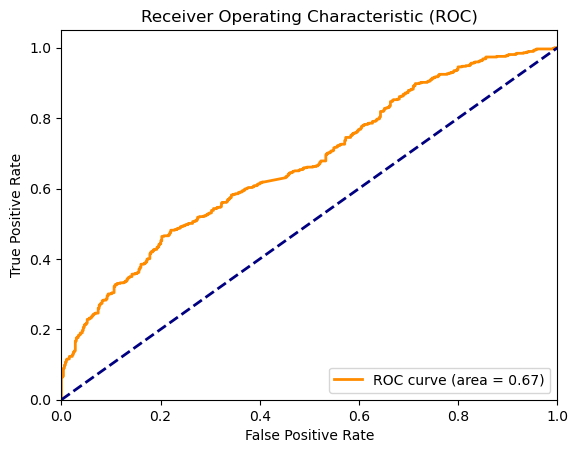

AUC: 0.6678
Accuracy: 0.6067


In [7]:



#Save the model
model.save('resized/223d_cnn_model.h5')
model.save('resized/223d_cnn_model.keras')

# Load the model (example)
loaded_model_h5 = tf.keras.models.load_model('resized/223d_cnn_model.h5')
loaded_model_keras = tf.keras.models.load_model('resized/223d_cnn_model.keras')


# In[8]:


from sklearn.metrics import accuracy_score

# Predict the labels for the test data
S_test_predictions = model.predict(S_test_data)

# Convert predictions to binary class labels if not already done
S_test_predictions_binary = (S_test_predictions > 0.5).astype(int)  # Assuming binary classification

# Calculate accuracy
accuracy = accuracy_score(S_test_labels, S_test_predictions_binary)
print(f"Test Accuracy: {accuracy:.4f}")


# In[9]:


from sklearn.metrics import confusion_matrix

# Assuming you have your true labels (S_test_labels) and predictions (S_test_predictions)
S_test_predictions_binary = (S_test_predictions > 0.5).astype(int)  # Convert to binary if needed

# Compute confusion matrix
conf_matrix = confusion_matrix(S_test_labels, S_test_predictions_binary)
print("Confusion Matrix:\n", conf_matrix)


# In[10]:


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(S_test_labels, S_test_predictions)

# Compute AUC
roc_auc = roc_auc_score(S_test_labels, S_test_predictions)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.4f}")


# In[11]:


from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(S_test_labels, S_test_predictions_binary)
print(f"Accuracy: {accuracy:.4f}")


# In[ ]:




